In [1]:
import pandas as pd
df = pd.read_csv(r"C:\Users\jairo\OneDrive - Pontificia Universidad Javeriana\Desktop\SUPPORT-VECTOR-MACHINE-CLASSIFIER\Data\03 CSV data -- STC(A)_numerical dates.csv")

# PREPARACIÓN DE DATOS

In [2]:
# Librerías para manipulación y preparación del dataframe

import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

In [3]:
# Se elimina ID porque es un identificador único y no aporta información al modelo

df = df.drop(columns=["ID"], errors="ignore")

In [4]:
# Se detectan automáticamente columnas que contienen "Date"

date_cols = [col for col in df.columns if "Date" in col]

# Conversión a datetime
for col in date_cols:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Se crea una referencia temporal para transformar fechas a números
reference_date = df[date_cols].min().min()

# Se transforman a "días desde la fecha mínima"
for col in date_cols:
    df[col + "_days"] = (df[col] - reference_date).dt.days

# Se eliminan las columnas originales de fecha
df = df.drop(columns=date_cols)

In [5]:
# Convierte columnas tipo object a numéricas cuando es posible

for col in df.select_dtypes(include="object").columns:
    try:
        df[col] = pd.to_numeric(df[col])
    except:
        pass

In [6]:
# Se detecta automáticamente la columna objetivo que contiene "Retained"

target_col = [col for col in df.columns if "Retained" in col][0]

y = pd.to_numeric(df[target_col], errors="coerce")

X = df.drop(columns=[target_col])

In [7]:
# Separación automática por tipo de dato

num_cols = X.select_dtypes(include=["int64", "float64"]).columns
cat_cols = X.select_dtypes(include=["object", "category"]).columns

In [8]:
# Agrupa categorías poco frecuentes en "OTHER"
# Evita expansión excesiva en el OneHotEncoding

max_categories = 20

for col in cat_cols:
    top = X[col].value_counts().nlargest(max_categories).index
    X[col] = np.where(X[col].isin(top), X[col], "OTHER")

In [9]:
# Para numéricas:
# imputación con mediana (robusta a outliers)
# escalado obligatorio para SVM

num_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler())
])

In [10]:
# Para categóricas:
# imputación de missing como categoría
# OneHotEncoding para convertir a variables binarias

cat_pipeline = Pipeline([
    ("imputer", SimpleImputer(strategy="constant", fill_value="Missing")),
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

In [11]:
# Aplica cada pipeline según el tipo de columna

preprocess = ColumnTransformer([
    ("num", num_pipeline, num_cols),
    ("cat", cat_pipeline, cat_cols)
])

In [12]:
# Ajusta el preprocesador y transforma los datos
# El resultado es una matriz numérica lista para SVM

X_prepared = preprocess.fit_transform(X)

In [13]:
# Se obtienen los nombres de las columnas generadas por el preprocesamiento
feature_names = preprocess.get_feature_names_out()

# Se convierte a matriz densa si el resultado es sparse
X_prepared_dense = X_prepared.toarray() if hasattr(X_prepared, "toarray") else X_prepared

# Se construye el DataFrame final listo para el modelo
X_prepared = pd.DataFrame(
    X_prepared_dense,
    columns=feature_names,
    index=X.index
)

In [14]:
#ESTOS SON LOS DATOS LISTOS PARA EL SVM
X_prepared
y

0       1
1       1
2       1
3       0
4       0
       ..
2384    0
2385    1
2386    1
2387    1
2388    1
Name: Retained.in.2012., Length: 2389, dtype: int64

# Aplicación SVM

In [15]:
# Librerías necesarias para entrenar el modelo y evaluar desempeño

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

In [16]:
# Se divide el dataset en entrenamiento y prueba
# stratify=y mantiene la proporción de clases en ambos conjuntos
# test_size=0.2 usa 20% para evaluación

X_train, X_test, y_train, y_test = train_test_split(
    X_prepared,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [17]:
# Se define el modelo SVM
# kernel="rbf" permite capturar relaciones no lineales
# class_weight="balanced" compensa desbalance de clases automáticamente

svm_model = SVC(
    kernel="linear",
    class_weight="balanced",
    probability=True,   # necesario para calcular ROC-AUC
    random_state=42
)

In [18]:
# El modelo aprende los patrones a partir de los datos de entrenamiento

svm_model.fit(X_train, y_train)

,"C C: float, default=1.0Regularization parameter. The strength of the regularization isinversely proportional to C. Must be strictly positive. The penaltyis a squared l2 penalty. For an intuitive visualization of the effectsof scaling the regularization parameter C, see:ref:`sphx_glr_auto_examples_svm_plot_svm_scale_c.py`.",1.0
,"kernel kernel: {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'} or callable, default='rbf'Specifies the kernel type to be used in the algorithm. Ifnone is given, 'rbf' will be used. If a callable is given it is used topre-compute the kernel matrix from data matrices; that matrix should bean array of shape ``(n_samples, n_samples)``. For an intuitivevisualization of different kernel types see:ref:`sphx_glr_auto_examples_svm_plot_svm_kernels.py`.",'linear'
,"degree degree: int, default=3Degree of the polynomial kernel function ('poly').Must be non-negative. Ignored by all other kernels.",3
,"gamma gamma: {'scale', 'auto'} or float, default='scale'Kernel coefficient for 'rbf', 'poly' and 'sigmoid'.- if ``gamma='scale'`` (default) is passed then it uses 1 / (n_features * X.var()) as value of gamma,- if 'auto', uses 1 / n_features- if float, must be non-negative... versionchanged:: 0.22 The default value of ``gamma`` changed from 'auto' to 'scale'.",'scale'
,"coef0 coef0: float, default=0.0Independent term in kernel function.It is only significant in 'poly' and 'sigmoid'.",0.0
,"shrinking shrinking: bool, default=TrueWhether to use the shrinking heuristic.See the :ref:`User Guide `.",True
,"probability probability: bool, default=FalseWhether to enable probability estimates. This must be enabled priorto calling `fit`, will slow down that method as it internally uses5-fold cross-validation, and `predict_proba` may be inconsistent with`predict`. Read more in the :ref:`User Guide `.",True
,"tol tol: float, default=1e-3Tolerance for stopping criterion.",0.001
,"cache_size cache_size: float, default=200Specify the size of the kernel cache (in MB).",200
,"class_weight class_weight: dict or 'balanced', default=NoneSet the parameter C of class i to class_weight[i]*C forSVC. If not given, all classes are supposed to haveweight one.The ""balanced"" mode uses the values of y to automatically adjustweights inversely proportional to class frequencies in the input dataas ``n_samples / (n_classes * np.bincount(y))``.",'balanced'
,"verbose verbose: bool, default=FalseEnable verbose output. Note that this setting takes advantage of aper-process runtime setting in libsvm that, if enabled, may not workproperly in a multithreaded context.",False


In [39]:
# Predicciones de clase sobre el conjunto de prueba

y_pred_base = svm_model.predict(X_test)

# Probabilidades para métricas como ROC-AUC

y_proba_base = svm_model.predict_proba(X_test)[:, 1]


In [40]:
# Se calculan las métricas de evaluación del modelo (base line hace referencia a que es el modelo base que luego se comparará con el modelo del tuning)

accuracy_baseline  = accuracy_score(y_test, y_pred_base)
precision_baseline = precision_score(y_test, y_pred_base)
recall_baseline    = recall_score(y_test, y_pred_base)
f1_baseline        = f1_score(y_test, y_pred_base)
roc_auc_baseline   = roc_auc_score(y_test, y_proba_base)

print("Accuracy :", accuracy_baseline)
print("Precision:", precision_baseline)
print("Recall   :", recall_baseline)
print("F1-score :", f1_baseline)
print("ROC-AUC  :", roc_auc_baseline)

Accuracy : 0.7866108786610879
Precision: 0.8455882352941176
Recall   : 0.7931034482758621
F1-score : 0.8185053380782918
ROC-AUC  : 0.8517699926632428


In [41]:
# Muestra precision, recall y F1 por clase

print(classification_report(y_test, y_pred_base))

              precision    recall  f1-score   support

           0       0.71      0.78      0.74       188
           1       0.85      0.79      0.82       290

    accuracy                           0.79       478
   macro avg       0.78      0.78      0.78       478
weighted avg       0.79      0.79      0.79       478



In [42]:
# Permite ver errores de clasificación por tipo

print(confusion_matrix(y_test, y_pred_base))

[[146  42]
 [ 60 230]]


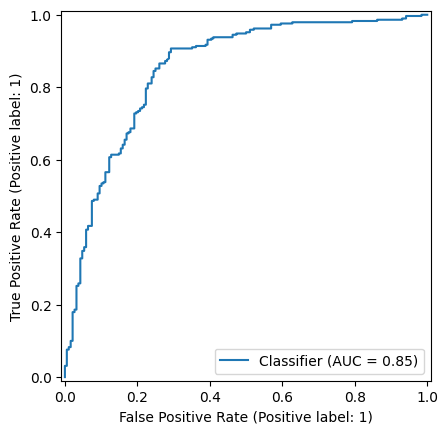

In [43]:
# Visualiza la capacidad del modelo para separar clases

RocCurveDisplay.from_predictions(y_test, y_proba_base)

# Fine tuning de hiperparametos para el SVM

In [25]:
# Librerías para validación cruzada, búsqueda de hiperparámetros y métricas

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_auc_score,
    classification_report,
    confusion_matrix,
    RocCurveDisplay
)

import matplotlib.pyplot as plt

In [26]:
# Se divide el dataset en entrenamiento y prueba manteniendo proporción de clases

X_train, X_test, y_train, y_test = train_test_split(
    X_prepared,
    y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

In [27]:
# Modelo SVM sin especificar kernel
# Los hiperparámetros se optimizarán en el GridSearch

svm = SVC(
    probability=True,
    class_weight="balanced",
    random_state=42
)

In [28]:
# Se define el espacio de búsqueda para los hiperparámetros más relevantes

param_grid = [

    # Configuración para kernel lineal
    {
        "kernel": ["linear"],
        "C": [0.01, 0.1, 1, 10, 100]
    },

    # Configuración para kernel RBF
    {
        "kernel": ["rbf"],
        "C": [0.1, 1, 10, 100],
        "gamma": ["scale", 0.01, 0.1, 1]
    }
]

In [29]:
# Se ejecuta la búsqueda de hiperparámetros
# scoring="roc_auc" porque es la métrica más robusta para este problema

grid = GridSearchCV(
    svm,
    param_grid,
    scoring="roc_auc",
    cv=5,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

Fitting 5 folds for each of 21 candidates, totalling 105 fits


,"estimator estimator: estimator objectThis is assumed to implement the scikit-learn estimator interface.Either estimator needs to provide a ``score`` function,or ``scoring`` must be passed.",SVC(class_wei...ndom_state=42)
,"param_grid param_grid: dict or list of dictionariesDictionary with parameters names (`str`) as keys and lists ofparameter settings to try as values, or a list of suchdictionaries, in which case the grids spanned by each dictionaryin the list are explored. This enables searching over any sequenceof parameter settings.","[{'C': [0.01, 0.1, ...], 'kernel': ['linear']}, {'C': [0.1, 1, ...], 'gamma': ['scale', 0.01, ...], 'kernel': ['rbf']}]"
,"scoring scoring: str, callable, list, tuple or dict, default=NoneStrategy to evaluate the performance of the cross-validated model onthe test set.If `scoring` represents a single score, one can use:- a single string (see :ref:`scoring_string_names`);- a callable (see :ref:`scoring_callable`) that returns a single value;- `None`, the `estimator`'s :ref:`default evaluation criterion ` is used.If `scoring` represents multiple scores, one can use:- a list or tuple of unique strings;- a callable returning a dictionary where the keys are the metric names and the values are the metric scores;- a dictionary with metric names as keys and callables as values.See :ref:`multimetric_grid_search` for an example.",'roc_auc'
,"n_jobs n_jobs: int, default=NoneNumber of jobs to run in parallel.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionchanged:: v0.20 `n_jobs` default changed from 1 to None",-1
,"refit refit: bool, str, or callable, default=TrueRefit an estimator using the best found parameters on the wholedataset.For multiple metric evaluation, this needs to be a `str` denoting thescorer that would be used to find the best parameters for refittingthe estimator at the end.Where there are considerations other than maximum score inchoosing a best estimator, ``refit`` can be set to a function whichreturns the selected ``best_index_`` given ``cv_results_``. In thatcase, the ``best_estimator_`` and ``best_params_`` will be setaccording to the returned ``best_index_`` while the ``best_score_``attribute will not be available.The refitted estimator is made available at the ``best_estimator_``attribute and permits using ``predict`` directly on this``GridSearchCV`` instance.Also for multiple metric evaluation, the attributes ``best_index_``,``best_score_`` and ``best_params_`` will only be available if``refit`` is set and all of them will be determined w.r.t this specificscorer.See ``scoring`` parameter to know more about multiple metricevaluation.See :ref:`sphx_glr_auto_examples_model_selection_plot_grid_search_digits.py`to see how to design a custom selection strategy using a callablevia `refit`.See :ref:`this example`for an example of how to use ``refit=callable`` to balance modelcomplexity and cross-validated score... versionchanged:: 0.20 Support for callable added.",True
,"cv cv: int, cross-validation generator or an iterable, default=NoneDetermines the cross-validation splitting strategy.Possible inputs for cv are:- None, to use the default 5-fold cross validation,- integer, to specify the number of folds in a `(Stratified)KFold`,- :term:`CV splitter`,- An iterable yielding (train, test) splits as arrays of indices.For integer/None inputs, if the estimator is a classifier and ``y`` iseither binary or multiclass, :class:`StratifiedKFold` is used. In allother cases, :class:`KFold` is used. These splitters are instantiatedwith `shuffle=False` so the splits will be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here... versionchanged:: 0.22 ``cv`` default value if None changed from 3-fold to 5-fold.",5
,"verbose verbose: intControls the verbosity: the higher, the more messages.- >1 : the computation time for each fold and paramete

In [30]:
# Se muestran los mejores hiperparámetros encontrados

print("Mejores hiperparámetros:")
grid.best_params_

Mejores hiperparámetros:


{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'}

In [31]:
# Se obtiene el mejor modelo según la validación cruzada

best_model = grid.best_estimator_

In [32]:
# Predicciones del mejor modelo sobre el conjunto de prueba

y_pred = best_model.predict(X_test)

# Probabilidades para calcular ROC-AUC

y_proba = best_model.predict_proba(X_test)[:, 1]

In [33]:
# Cálculo de métricas principales

accuracy  = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall    = recall_score(y_test, y_pred)
f1        = f1_score(y_test, y_pred)
roc_auc   = roc_auc_score(y_test, y_proba)

print("Accuracy :", accuracy)
print("Precision:", precision)
print("Recall   :", recall)
print("F1-score :", f1)
print("ROC-AUC  :", roc_auc)

Accuracy : 0.7949790794979079
Precision: 0.8478260869565217
Recall   : 0.8068965517241379
F1-score : 0.8268551236749117
ROC-AUC  : 0.8633070432868671


In [34]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.72      0.78      0.75       188
           1       0.85      0.81      0.83       290

    accuracy                           0.79       478
   macro avg       0.79      0.79      0.79       478
weighted avg       0.80      0.79      0.80       478



In [35]:
print(confusion_matrix(y_test, y_pred))

[[146  42]
 [ 56 234]]


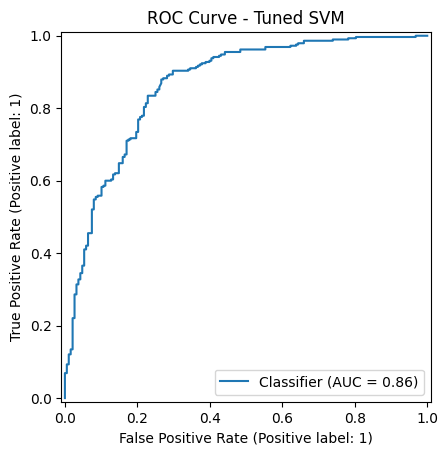

In [36]:
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("ROC Curve - Tuned SVM")
plt.show()

In [44]:
#Comparacion entre el modelo base y el modelo tuneado


print("Accuracy baseline :", accuracy_baseline)
print("Accuracy tuned    :", accuracy)

print("\nPrecision baseline :", precision_baseline)
print("Precision tuned    :", precision)

print("\nRecall baseline :", recall_baseline)
print("Recall tuned    :", recall)

print("\nF1 baseline :", f1_baseline)
print("F1 tuned    :", f1)

print("\nROC-AUC baseline :", roc_auc_baseline)
print("ROC-AUC tuned    :", roc_auc)

Accuracy baseline : 0.7866108786610879
Accuracy tuned    : 0.7949790794979079

Precision baseline : 0.8455882352941176
Precision tuned    : 0.8478260869565217

Recall baseline : 0.7931034482758621
Recall tuned    : 0.8068965517241379

F1 baseline : 0.8185053380782918
F1 tuned    : 0.8268551236749117

ROC-AUC baseline : 0.8517699926632428
ROC-AUC tuned    : 0.8633070432868671


# Comparación de resultados base vs aplicando tuning en hiperparametros del SVM



El proceso de ajuste de hiperparámetros produjo mejoras consistentes en todas las métricas evaluadas respecto al modelo base.

### Accuracy
- **Baseline:** 0.7866  
- **Tuned:** 0.7950  

Se observa un incremento en la exactitud global, lo que indica que el modelo ajustado clasifica correctamente un mayor porcentaje de observaciones. Aunque la mejora es moderada, es consistente con el ajuste fino de los hiperparámetros.

---

### Precision
- **Baseline:** 0.8456  
- **Tuned:** 0.8478  

La precisión aumenta ligeramente. Esto significa que, de los clientes que el modelo predice como retenidos, una proporción mayor realmente lo está. En términos de negocio, implica una mejor focalización de las campañas de retención.

---

### Recall
- **Baseline:** 0.7931  
- **Tuned:** 0.8069  

Se observa una mejora clara en el recall, lo que indica que el modelo tuneado identifica una mayor proporción de clientes que efectivamente se retienen. Esto es importante porque reduce la cantidad de clientes retenidos que el modelo no logra detectar.

---

### F1-score
- **Baseline:** 0.8185  
- **Tuned:** 0.8269  

El incremento en el F1-score muestra que el modelo ajustado logra un mejor balance entre precision y recall, lo que representa una mejora real en la capacidad de clasificación de la clase positiva.

---

### ROC-AUC
- **Baseline:** 0.8518  
- **Tuned:** 0.8633  

El aumento del ROC-AUC indica que el modelo tuneado tiene una mejor capacidad para separar clientes retenidos de no retenidos, independientemente del umbral de decisión. Esta métrica es especialmente relevante en este problema, ya que permite ordenar los clientes según su probabilidad de retención y priorizar estrategias de intervención.

---

## Interpretación del comportamiento del modelo

El mejor desempeño del modelo ajustado sugiere que la relación entre las variables y la retención no es estrictamente lineal, y que el uso de kernels más flexibles permite capturar patrones más complejos en los datos.

El valor óptimo del hiperparámetro **C** logra un equilibrio adecuado entre la complejidad del modelo y su capacidad de generalización, evitando tanto el subajuste como el sobreajuste.

Además, el incremento en el ROC-AUC confirma que el modelo tuneado mejora la capacidad de discriminación entre clases, lo que lo hace más útil para la toma de decisiones en estrategias de retención.

---

## Conclusión

El modelo SVM ajustado se selecciona como el mejor para este problema porque:

- Mejora todas las métricas de desempeño respecto al modelo base.
- Incrementa la capacidad de discriminación entre clientes retenidos y no retenidos.
- Logra un mejor equilibrio entre precision y recall.
- Captura relaciones no lineales presentes en los datos.

Aunque las mejoras son moderadas, son consistentes en todas las métricas, lo que indica que el ajuste de hiperparámetros optimizó el rendimiento del modelo sin introducir sobreajuste, algo especialmente relevante dado el tamaño del dataset.